## Assignment 3: Evaluating Image Classifier Models with Saliency Maps
### Sean Y.

> Convolutional Neural Networks (ConvNets or CNNs) have gained massive popularity in recent years, mostly being used to analyze visual imagery. Their applications are wide-ranging, from simple binary classifiers to complex models that are used in hospitals to identify tumors. Despite being so widely used, CNNs are still somewhat of a black box: it is not always clear “why” a model makes the prediction that it does. Without this information, how can researchers and developers be sure their models will work in the real world?

> One way we can analyze how an image classifier model makes its predictions is by using tools like TruLens and Keras-vis. These analytical tools can help generate attention heatmaps for input images, showing us just where the model is looking when it makes a prediction. Additionally, tools like TruLens provides additional insights such as being able to see the most important feature map in each layer, giving us important information for evaluating our models.


In [6]:
# Here are all the imports that we'll need. Please comment out if you have them installed (not neccessary just for peace of mind).
import sys
!{sys.executable} -m pip install trulens
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install torchsummary
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install IPython
!{sys.executable} -m pip install numpy --upgrade
!{sys.executable} -m pip install Pillow

You should consider upgrading via the 'C:\Users\seany\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\seany\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\seany\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\seany\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\seany\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\seany\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\seany\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\seany\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\seany\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\seany\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\seany\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [8]:
# Import all the libraries we'll need

import json
import PIL
import requests
import scipy.misc
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import tensorflow as tf
import torchvision.utils as utils
import torchvision.models as models
import torchvision.transforms as transforms
from IPython.display import Image, display
from tensorflow import keras
from torchsummary import summary
from torch.autograd import Variable
from trulens.nn.attribution import InputAttribution
from trulens.nn.attribution import IntegratedGradients
from trulens.visualizations import ChannelMaskVisualizer
from trulens.visualizations import MaskVisualizer
from trulens.visualizations import HeatmapVisualizer
from trulens.nn.models import get_model_wrapper
from trulens.nn.attribution import InternalInfluence
from trulens.nn.distributions import PointDoi
from trulens.nn.quantities import ClassQoI, InternalChannelQoI, MaxClassQoI
from trulens.nn.slices import Cut, InputCut, OutputCut, Slice

In [9]:
# Display matplotlib figures in the cell
%matplotlib inline

In [10]:
# Suppress large deprecated warning generated by creating pytorch model
import warnings
warnings.filterwarnings('ignore')

### VGG16, a quick introduction

> Now that the environment is setup, we’ll be importing a pre-trained VGG16 model from pyTorch. Just as a quick introduction, VGG16 is a CNN developed by the Visual Geometry Group from Oxford University. This model won the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2014, and is widely considered one of the best image classifier models to currently exist. It is able to classify over 1000 objects with ~93% accuracy. The 16 in VGG16 stands for 16 weighted layers (13 Convolution layers and 3 Dense layers).

> This next block of code imports the pre-trained model and creates a wrapped model with TruLens, which we will use later for analysis. It will also print out a quick summary of the model, showing layers and output shapes.

In [11]:
# Create a Pytorch VGG16 model
pytorch_model = models.vgg16(pretrained=True)
device = 'cpu'

# Produce a wrapped model from the pytorch model for Trulens.
wrapped_model = get_model_wrapper(pytorch_model, input_shape=(3,224,224), device=device)

INFO: lib level=1
INFO: root level=30
INFO: Detected pytorch backend for <class 'torchvision.models.vgg.VGG'>.
INFO: Changing backend from None to Backend.PYTORCH.
INFO: If this seems incorrect, you can force the correct backend by passing the `backend` parameter directly into your get_model_wrapper call.


In [12]:
print(summary(pytorch_model, (3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### Here I downloaded a beaglebike image from google but feel free to upload any image.

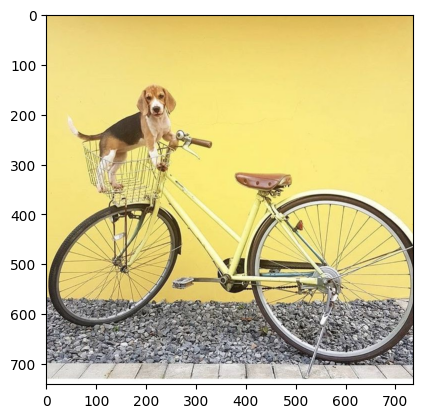

In [6]:
url = "beaglebike.jpg"
#url = "beagle_blackbike.jpg"
#url = "cat_on_car.jpg"
#url = "bear_in_kitchen.png"

with PIL.Image.open(url) as img:
    x = np.array(img.resize((224,224), PIL.Image.ANTIALIAS))[np.newaxis]

    # Pre-process uploaded image
    normalize = transforms.Compose([
        transforms.ToTensor(), # convert to [0, 1]
        
        # these are the means and stddevs of ImageNet (calculated from their image library)
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])])
    x_pp = np.array(normalize(x[0])).transpose(1, 2, 0)[np.newaxis]

    # Transpose to [*, C, H, W] for PyTorch convention.
    x = x.transpose(0, 3, 1, 2)
    x_pp = x_pp.transpose(0, 3, 1, 2)
    plt.imshow(img)

### Collecting image at each convolution layer

> Now that the model and input image are ready, we can make predictions. Before we pass the image through the model, we use the following code to collect some useful information along the way. This code will collect all the convolution layers. 

In [7]:
# we will save the conv layer weights in this list
model_weights =[]

#we will save the 13 conv layers in this list
conv_layers = []

# get all the model children as list
model_children1 = list(pytorch_model.children())
model_children = model_children1[0]

#counter to keep count of the conv layers
counter = 0

#append all the conv layers and their weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")

Total convolution layers: 13
conv_layers


In [8]:
# run the model with cuda if available, else use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x_model = pytorch_model.to(device)

In [12]:
# show how transformations change image shape
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])])
image = transform(img)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

Image shape before: torch.Size([3, 224, 224])
Image shape after: torch.Size([1, 3, 224, 224])


In [13]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
    
joined = list(zip(names,outputs))    
for i in joined:
    print(f"Name: {i[0]}; Shape:{i[1].shape}")

Name: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)); Shape:torch.Size([1, 64, 224, 224])
Name: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)); Shape:torch.Size([1, 64, 224, 224])
Name: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)); Shape:torch.Size([1, 128, 224, 224])
Name: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)); Shape:torch.Size([1, 128, 224, 224])
Name: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)); Shape:torch.Size([1, 256, 224, 224])
Name: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)); Shape:torch.Size([1, 256, 224, 224])
Name: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)); Shape:torch.Size([1, 256, 224, 224])
Name: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)); Shape:torch.Size([1, 512, 224, 224])
Name: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)); Shape:torch.Size([1, 512, 224, 224])


In [14]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())

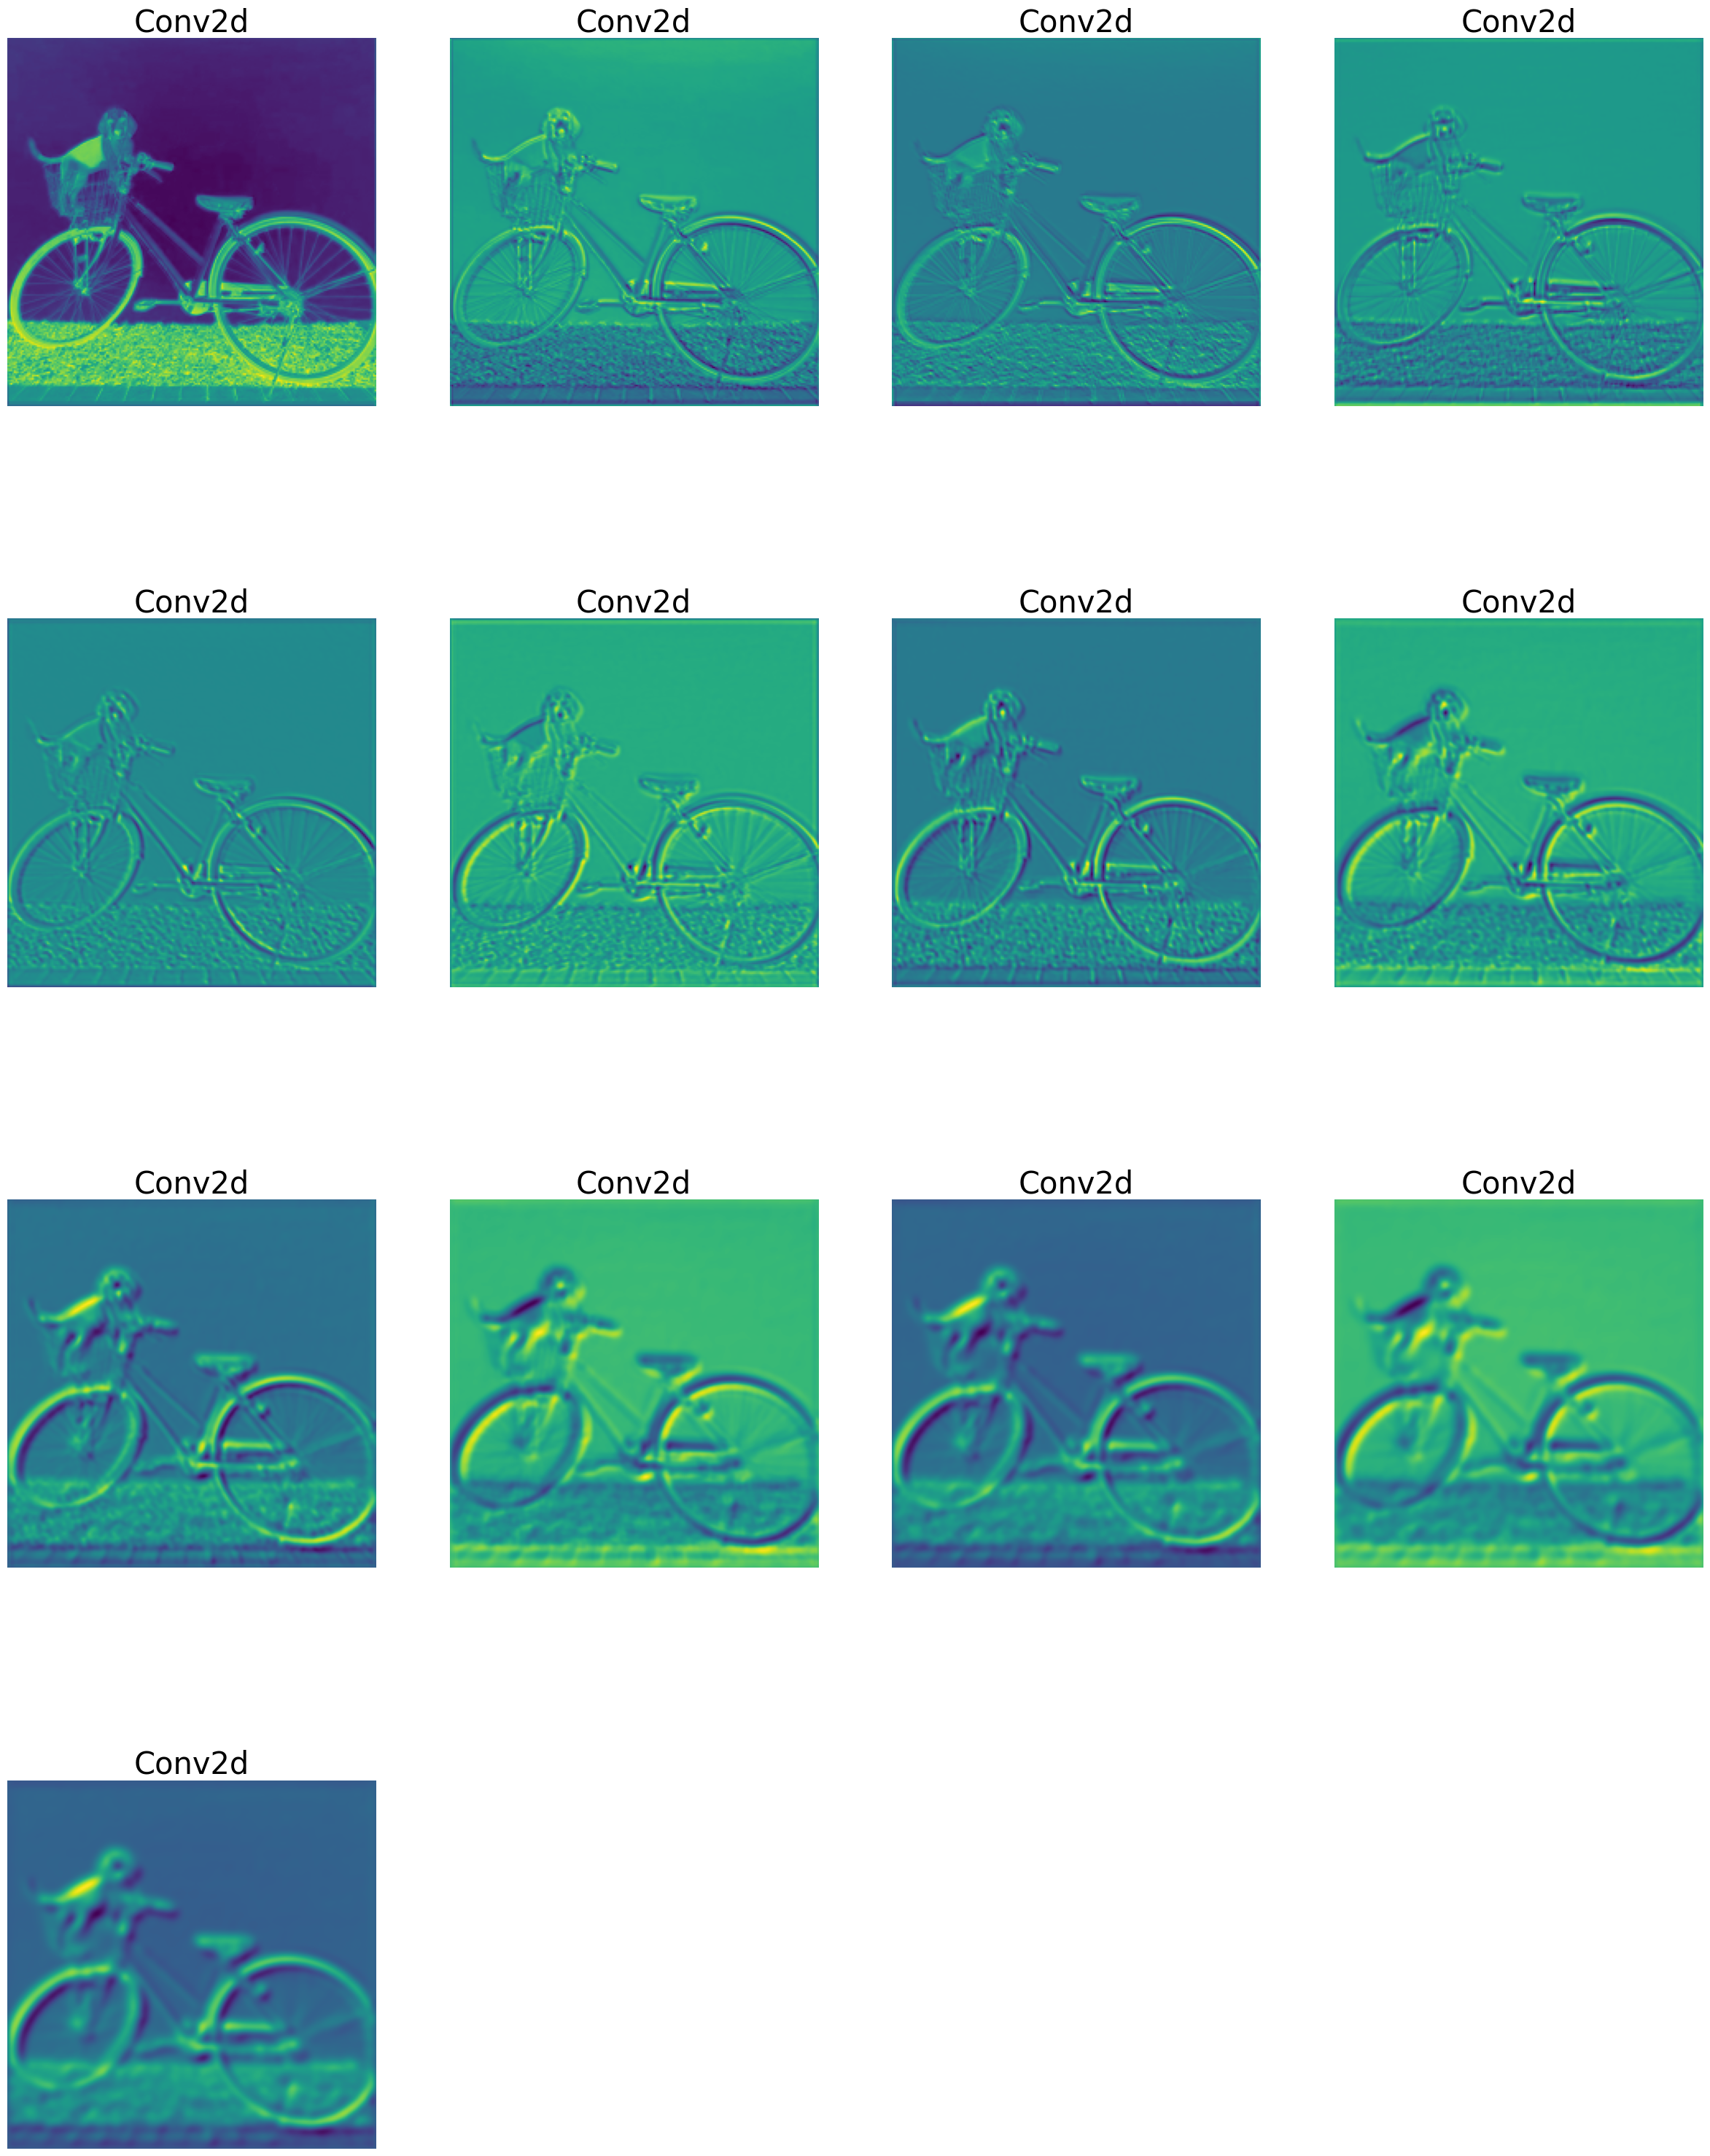

In [15]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

In [16]:
# Make predictions using pytorch model and write them to output
with torch.no_grad():
    output = pytorch_model(torch.from_numpy(x_pp).to('cpu')).cpu().numpy()
    df = pd.DataFrame(output)
    df = df.transpose()
df

0
0   -2.329314
1   -2.067582
2   -1.638957
3   -2.829942
4   -0.295750
..        ...
995 -0.321406
996 -0.289111
997 -2.064857
998  2.092905
999  2.920042

[1000 rows x 1 columns]

In [17]:
# Open classifications file
with open('imagenet_class_index.json') as file:
    classes_index = json.load(file)
    
    
# change indexes to labels
labels_from_index = [classes_index[str(x)][1] for x in range(len(classes_index))]
top_labels = [
    (j, labels_from_index[j], output[0][j]) 
    for j in np.argsort(output[0])[::-1][:10]] 

# Top 10 predictions of image by pytorch VGG16
df = pd.DataFrame(top_labels, columns=["Index", "Name", "Score"])
df

Index                   Name     Score
0    444  bicycle-built-for-two  8.362379
1    870               tricycle  7.495786
2    671          mountain_bike  6.707326
3    171      Italian_greyhound  5.635993
4    176                 Saluki  5.066577
5    172                whippet  4.987955
6    535             disk_brake  4.946868
7    251              dalmatian  4.840751
8    823            stethoscope  4.704613
9    612             jinrikisha  4.698260

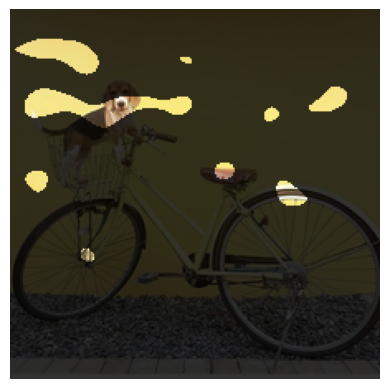

In [18]:
from trulens.nn.attribution import InputAttribution
from trulens.nn.attribution import IntegratedGradients
from trulens.visualizations import MaskVisualizer

# Saliency maps in Trulens are implemented by the InputAttribution class
# It takes a ModelWrapper object and from the attributions class, we can get several visualizations

# The first is this MaskVisualizer, which takes a blur and threshold argument and uses those to overlay
# a mask over the image revealing the top threshold precentage of pixels by attribution

infl = InputAttribution(wrapped_model)
attrs_input = infl.attributions(x_pp)

masked_image = MaskVisualizer(blur=10, threshold=0.95)(attrs_input, x)

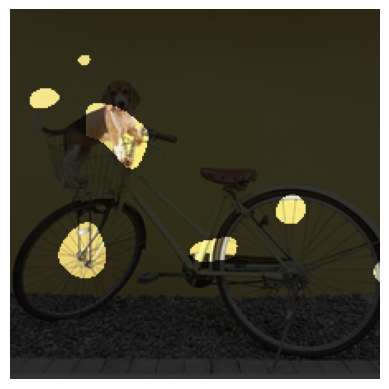

In [19]:
# Another cool visualization feature from Trulens is the IntegratedGradients workflow
# It obtains attributions through Integrated Gradients which computes the gradient of the 
# model’s prediction output to its input features

infl = IntegratedGradients(wrapped_model, resolution=10)
attrs_input = infl.attributions(x_pp)
masked_image = MaskVisualizer(blur=10, threshold=0.95)(attrs_input, x)

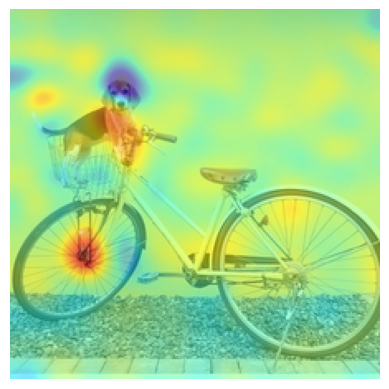

In [20]:
# One final important feature is the heatmap visualization which most clearly shows 
# you where the model is looking within an image

infl = IntegratedGradients(wrapped_model, resolution=10)
attrs_input = infl.attributions(x_pp)
masked_image = HeatmapVisualizer(blur=10)(attrs_input, x)

In [21]:
from trulens.nn.attribution import InternalInfluence
from trulens.nn.distributions import PointDoi
from trulens.nn.quantities import ClassQoI, InternalChannelQoI, MaxClassQoI
from trulens.nn.slices import Cut, InputCut, OutputCut, Slice

# The most important feature of Trulens however is being able to calculate attributions for individual neurons
# within your model. ie. Trulens can tell you which Feature Maps in each layer are critical in model decision making

# Trulens does this with the InternalInfluence object which takes a Trulens ModelWrapper
# it requires a Slice, QoI (quantity of interest), and DoI (distribution of interest)

# Slice defines a layer to use for internal attributions 
# the QoI defines the model behavior we want to explain using attributions, it is the output of some layer
# the DoI specifies points surrounding each record for faithful attribution calculations

# Define the influence measure.
infl = InternalInfluence(
    wrapped_model, 
    Slice(Cut('features_28'), OutputCut()), 
    MaxClassQoI(),
    PointDoi())

attrs_internal = infl.attributions(x_pp).sum(axis=(2,3))

In [22]:
# Define the influence measure.
infl = InternalInfluence(wrapped_model, 'features_28', 'max', 'point')

# Get the attributions for the internal neurons at layer 'features_28'. Because 
# layer 'features_28' contains 2D feature maps, we take the sum over the width 
# and height of the feature maps to obtain a single attribution for each feature 
# map.
attrs_internal = infl.attributions(x_pp).sum(axis=(2,3))
print(f"Number of neurons in layer features_28: {len(attrs_internal[0])}")

Number of neurons in layer features_28: 512


In [23]:
top_feature_map = int(attrs_internal[0].argmax())

print('Top feature map:', top_feature_map)

Top feature map: 338


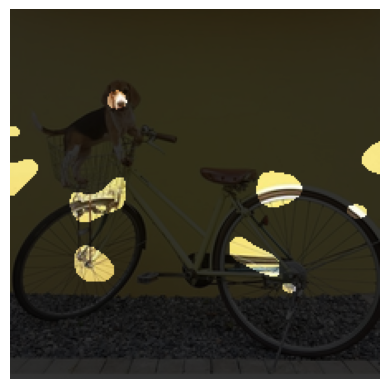

In [24]:
# Since feature maps represent learned features we cant easily interepret them
# But Trulens can use a second set of attributions to find input features that are most important 
# in defining THIS particular feature map

masked_image = ChannelMaskVisualizer(
    wrapped_model,
    'features_28',
    top_feature_map,
    blur=10,
    threshold=0.95)(x, x_pp)
plt.axis('off')
plt.imshow(masked_image[0].transpose((1,2,0)))

In [25]:
# Create the same model with Keras
model_builder = keras.applications.vgg16.VGG16
img_size = (224, 224)
preprocess_input = keras.applications.vgg16.preprocess_input
decode_predictions = keras.applications.vgg16.decode_predictions
last_conv_layer_name = "block5_conv3"
    
# Make model
keras_model = model_builder(weights="imagenet")
print(keras_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

1/1 [==============================] - 0s 290ms/step


ID             Prediciton      Score
0  n02835271  bicycle-built-for-two  12.375878
1  n03792782          mountain_bike  10.835170
2  n04482393               tricycle  10.714136
3  n02110063               malamute   7.495910
4  n09428293               seashore   7.127632
5  n09193705                    alp   6.688909
6  n09421951                sandbar   6.464908
7  n03930313           picket_fence   6.434454
8  n03599486             jinrikisha   6.306470
9  n04039381                 racket   6.091427

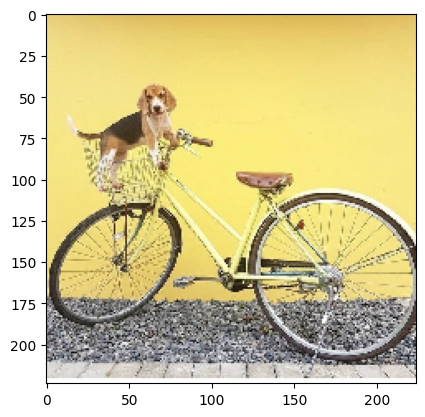

In [26]:
# The Heatmap process in Keras-Vis
# Trulens basically expands on the work done by keras-vis already, here is a saliency map example generated by keras-vis

# Remove last layer's softmax
keras_model.layers[-1].activation = None

img = keras.preprocessing.image.load_img(url, target_size=img_size)
plt.imshow(img)

# `array` is a float32 Numpy array of shape (299, 299, 3)
array = keras.preprocessing.image.img_to_array(img)

# add a dimension to transform our array into a "batch"
# of size (1, 299, 299, 3)
img_array = np.expand_dims(array, axis=0)

# Print what the top predicted class is
preds = keras_model.predict(img_array)
predicted_string = decode_predictions(preds, top=10)[0]
data_preds = pd.DataFrame(predicted_string, columns=["ID", "Prediciton", "Score"])
data_preds


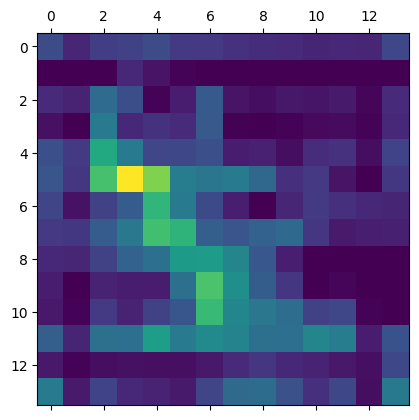

In [27]:
# First, we create a model that maps the input image to the activations
# of the last conv layer as well as the output predictions
grad_model = tf.keras.models.Model(
    [keras_model.inputs], [keras_model.get_layer(last_conv_layer_name).output, keras_model.output]
)

pred_index=None

# Then, we compute the gradient of the top predicted class for our input image
# with respect to the activations of the last conv layer
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    if pred_index is None:
        pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]

# This is the gradient of the output neuron (top predicted or chosen)
# with regard to the output feature map of the last conv layer
grads = tape.gradient(class_channel, last_conv_layer_output)

# This is a vector where each entry is the mean intensity of the gradient
# over a specific feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the top predicted class
# then sum all the channels to obtain the heatmap class activation
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# For visualization purpose, we will also normalize the heatmap between 0 & 1
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

heatmap = heatmap.numpy()
plt.matshow(heatmap)

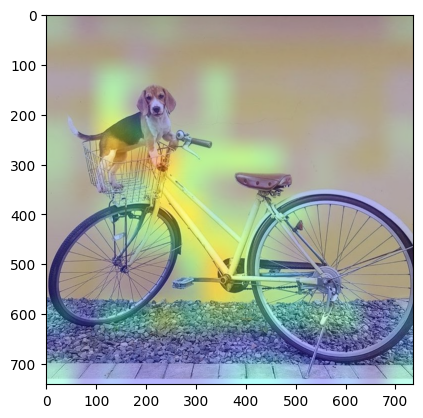

In [28]:
img = keras.preprocessing.image.load_img(url)
img = keras.preprocessing.image.img_to_array(img)

# Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# Use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

plt.imshow(superimposed_img)